In [1]:
# word2vec
from gensim.models import Word2Vec, KeyedVectors

# handling files
import json
import glob
import csv

# handling data
import numpy as np
import pandas as pd
import math
from scipy.stats import spearmanr
import re
from scipy.spatial.distance import cosine

# handy implementations
from collections import defaultdict
from itertools import combinations, permutations
from collections import Counter

# misc
import matplotlib.pyplot as plt
from  warnings import warn

/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.25.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
authors = sorted(["marx_engels", "stalin", "trotzki", "kautsky", "lenin", "gramsci", "luxemburg", "thaelmann", "bernstein", "mao"])

In [4]:
all_terms = {"Politische Ökonomie": ["wert", "ware", "klasse"],
             "Philosophie": ["dialektik", "widerspruch", "aufhebung"],
             "Staatstheorie": ["staat", "bürokratie", "diktatur"],
             "Sozialismusverständnis": ["sozialismus", "diktatur"],
             "Strategie und Taktik": ["revolution", "bündnis", "reform"]}
all_terms = {cat: [w+"_n" for w in words] for cat, words in all_terms.items()}
term_cats = sorted(all_terms.keys())

In [51]:
all_terms_weird = {"Politische Ökonomie": ["wert", "schuh", "nase"],
             "Philosophie": ["dialektik", "messer", "regen"],
             "Staatstheorie": ["staat", "ei", "stuhl"],
             "Sozialismusverständnis": ["sozialismus", "mehl"],
             "Strategie und Taktik": ["revolution", "baum", "haus"]}
all_terms_weird = {cat: [w+"_n" for w in words] for cat, words in all_terms_weird.items()}
term_cats_weird = sorted(all_terms.keys())

# Create wordembeddings for subcorpora

## Load raw data

In [10]:
def load_data(files):
    data = []
    for f in files:
        with open(f) as inf:
            data.append(json.load(inf))   
    # return sentences in flat format, ignoring text or work boundaries
    return [sentence for works in data for texts in works.values() for sentence in texts]

In [11]:
raw_data = {}
for author in authors:
    raw_data[author] = load_data(glob.glob(f"../json/{author}/*"))

### annotate authors to key terms

In [14]:
terms = all_terms.values()
terms = list(set([v for t in terms for v in t]))

for author, sentences in raw_data.items():
    for i, sent in enumerate(sentences):
        for j, tok in enumerate(sent):
            for term in terms:
                if term == tok:
                    raw_data[author][i][j] = term + "_" + author

all_data = [sentences for data in raw_data.values() for sentences in data]

## Create and save models

### for subcorpora embeddings

In [5]:
models = {}
for author, sentences in raw_data.items():
    print(f"working on {author}...")
    models[author] = Word2Vec(sentences, size=300, min_count=5, window=100, workers=5, iter=15).wv  # only storing vectors
print("done.")

working on bernstein...
working on gramsci...
working on kautsky...
working on lenin...
working on luxemburg...
working on mao...
working on marx_engels...
working on stalin...
working on thaelmann...
working on trotzki...
done.


In [7]:
for author, model in models.items():
    model.save(f"../models/{author}_iter15.model")

### for annotated key terms

In [16]:
model = Word2Vec(all_data, size=300, min_count=5, window=100, workers=5, iter=15).wv

In [17]:
model.save("../models/all_annotated.model")

In [25]:
model.similarity("wert_n_stalin", "wert_n_marx_engels")

0.32301778

### as count vecors

In [12]:
# create vocabulary of whole corpus

# get all tokens, that are nouns or verbs
toks = [tok for sentences in raw_data.values() for sentence in sentences for tok in sentence if tok[-1] in ["n", "v"]]

# get only most common 10000 
vocab = Counter(toks).most_common(10000)
vocab = [w[0] for w in vocab]

del toks
vocab[:10]

['können_v',
 '0_n',
 'partei_n',
 'arbeiter_n',
 'land_n',
 'geben_v',
 'jahr_n',
 'machen_v',
 'revolution_n',
 'arbeit_n']

In [7]:
# create DataFrame with all appearances as pairs
this_authors = ["stalin", "thaelmann", "trotzki"]  # only work on 2 or 3 to prevent MemoryError
this_data = {k:v for k,v in raw_data.items() if k in this_authors}

for author, sentences in this_data.items():
    print(f"working on {author}...")
    appearances = {"target": [], "context": []}
    total = len(sentences)
    for i, sentence in enumerate(sentences):
        if i%500 == 0:
            print(f"\r{i}/{total} ({round((i/total)*100, 2)}%)", end="")
        filtered = filter(lambda x: x in vocab, sentence)
        for t, c in permutations(filtered, 2):
            appearances["target"].append(t)
            appearances["context"].append(c)
    this_model = pd.DataFrame(appearances)
    this_model = this_model.groupby(['target','context']).size().unstack(fill_value=0)
    this_model.to_pickle(f"../models/{author}_cnt.model")
    print()


working on stalin...
63500/63879 (99.41%)
working on thaelmann...
3000/3079 (97.43%)
working on trotzki...
55500/55826 (99.42%)



# Load pre-trained models

## Models for each author

In [47]:
# word2vec
models = {}
for author in authors:
    models[author] = KeyedVectors.load(f"../models/{author}_iter15.model", mmap="r")

In [3]:
# hand crafted count vectors
important = ["marx_engels", "stalin", "trotzki", "kautsky"]
models = {}
for author in important:
    models[author] = pd.read_pickle(f"../models/{author}_cnt.model")

## One model for all

In [85]:
model = KeyedVectors.load("../models/all_annotated.model", mmap="r")

FileNotFoundError: [Errno 2] No such file or directory: '../models/all_annotated.model.vectors.npy'

## inspect models

In [17]:
terms = sorted(list(set([t for ts in all_terms.values() for t in ts])))
authors = ["marx_engels", "stalin", "trotzki", "kautsky"]
combs = list(combinations(authors, 2))   

[('marx_engels', 'stalin'), ('marx_engels', 'trotzki'), ('marx_engels', 'kautsky'), ('stalin', 'trotzki'), ('stalin', 'kautsky'), ('trotzki', 'kautsky')]


,term,topN,marx_engels-stalin,marx_engels-trotzki,marx_engels-kautsky,stalin-trotzki,stalin-kautsky,trotzki-kautsky


In [50]:
terms = sorted(list(set([t for ts in all_terms.values() for t in ts])))
authors = ["marx_engels", "stalin", "trotzki", "kautsky"]
combs = combinations(authors, 2)

col_names = ["term", "topN"] + ["-".join(pair) for pair in combs]
data = pd.DataFrame(columns=col_names)

for m1, term in enumerate(terms):
    for m2, n in enumerate(range(100, 10001, 100)):
        print(f"\r{round((m1/len(terms) + (m2/100)/len(terms))*100, 3):.3f}%", end="")
        row = {"term": term, "topN": n}
        for a1, a2 in combs:
            a1_sims = [x[0] for x in models[a1].most_similar(term, topn=n)]
            a2_sims = [x[0] for x in models[a2].most_similar(term, topn=n)]
            row["-".join([a1,a2])] = len(set(a1_sims).intersection(set(a2_sims)))
        data = data.append(row, ignore_index=True)

data.head(100)

99.923%

,term,topN,marx_engels-stalin,marx_engels-trotzki,marx_engels-kautsky,stalin-trotzki,stalin-kautsky,trotzki-kautsky
0,aufhebung_n,100,NaN,NaN,NaN,NaN,NaN,NaN
1,aufhebung_n,200,NaN,NaN,NaN,NaN,NaN,NaN
2,aufhebung_n,300,NaN,NaN,NaN,NaN,NaN,NaN
3,aufhebung_n,400,NaN,NaN,NaN,NaN,NaN,NaN
4,aufhebung_n,500,NaN,NaN,NaN,NaN,NaN,NaN
5,aufhebung_n,600,NaN,NaN,NaN,NaN,NaN,NaN
6,aufhebung_n,700,NaN,NaN,NaN,NaN,NaN,NaN
7,aufhebung_n,800,NaN,NaN,NaN,NaN,NaN,NaN
8,aufhebung_n,900,NaN,NaN,NaN,NaN,NaN,NaN
9,aufhebung_n,1000,NaN,NaN,NaN,NaN,NaN,NaN


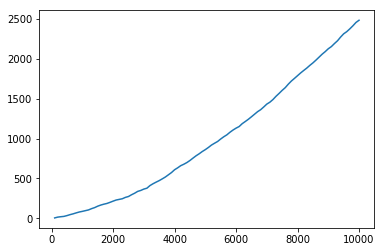

In [103]:
plt.plot([i for i in range(100, 10001, 100)], list(data["marx_engels-stalin"][100:200]))

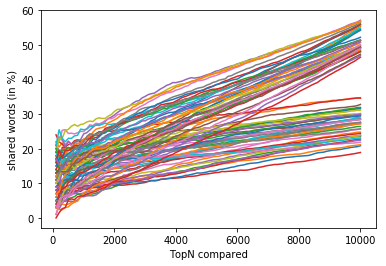

In [149]:
for pair in combs:
    for i in range(len(terms)):
        b = i*100
        e = b+100
        x_values = [i for i in range(100, 10001, 100)]
        y_values = np.array(100*data["-".join(pair)][b:e])/np.array(x_values)
        plt.plot(x_values, y_values)
plt.xlabel("TopN compared")
plt.ylabel("shared words (in %)")
plt.savefig("figures/shared_words.pdf")

# Create theory embeddings

In [37]:
class TheoryEmbeddings:
    def __init__(self, models, terms, word_number=50, min_similarity=None):
        # create posibillity to weigh terms
        if type(terms[0]) == tuple:
            self.terms = [t[0] for t in terms]
            self.term_weight = [t[1] for t in terms]
        else:
            self.terms = terms
        
        self.topn = {}
        self.compared_words = defaultdict(set)
        for author, model in models.items():
            this_topn = {}
            for term in self.terms:
                try:
                    this_topn[term] = model.most_similar(term, topn=word_number)
                except KeyError:
                    warn(f"'{term}' not in vocabulary of {author}!")
                    this_topn[term] = []
                if min_similarity is not None:
                    this_topn[term] = [w for w in this_topn[term] if w[1] >= min_similarity]
                self.compared_words[term].update(set(t[0] for t in this_topn[term]))
            self.topn[author] = this_topn
        self.compared_words = {term: sorted(list(words)) for term, words in self.compared_words.items()}
        
        self.vectors = defaultdict(lambda: defaultdict(list))
        for author, model in models.items():
            for term in terms:
                for contextword in self.compared_words[term]:
                    try:
                        v = model.similarity(term, contextword)
                    except KeyError:
                        v = 0.0
                    self.vectors[author][term].append(v)
                        
        

In [38]:
def rls(l1, l2):
    #if len(l1) != len(l2):
    #    raise ValueError("Both lists must be of same length")
    if len(l1) * len(l2) == 0:
        return np.nan
    val = 0
    inter = set(l1).intersection(set(l2))
    for t in inter:
        w1 = 1 - l1.index(t)/len(l1)
        w2 = 1 - l2.index(t)/len(l2)
        w = w1+w2
        #print(f"w1:{w1}, w2:{w2}, l1.index(t): {l1.index(t)}, len(l1):{len(l1)}")
        
        val += ((len(l1) - abs(l1.index(t) - l2.index(t)))*w)/1.2
    val /= len(l1)**2
    return val

In [39]:
def get_cnt_vector(word, model, pmi=False):
    # create empty vector
    if pmi:
        dtype = "float32"
    else:
        dtype = "int16"
    vector = np.zeros(len(vocab), dtype=dtype)
    
    # prepare not changing values for pmi
    if pmi:
        total = sum(model.sum())
        p_word = model[word].sum()/total
    
    # insert values into empty vector
    for w, v in model[word].items():
        i = vocab.index(w)
        if pmi:
            if v == 0:
                vector[i] = 0.
            else:
                num = v/total
                denom = (model[w].sum()/total) * p_word
                vector[i] = math.log(num/denom)
        else:
            vector[i] = v
        
    return vector

In [45]:
def theory_similarity(a1, a2, element, method="cos", threshold=None):
    print(f"{a1}, {a2}: {element}")
    if method not in ["cos", "rls", "aa", "cnt", "cnt_p"]:
        raise ValueError(f"Method '{method}' does not exist")
    
    if method == "cos":
        n = 50
    elif method == "rls":
        n = 1000
        
    terms = all_terms_weird[element]
    if method in ["cos", "rls"]:
        te = TheoryEmbeddings({a1: models[a1], a2: models[a2]}, terms, word_number=n, min_similarity=threshold)
    
    sims = []
    for term in terms:
        if method in ["cos", "rls"]:
            con1 = te.vectors[a1][term]
            con2 = te.vectors[a2][term]
        
        if method == "cos":
            sim = 1- cosine(con1, con2)
        elif method == "rls":
            sim = rls([t[0] for t in te.topn[a1][term]], [t[0] for t in te.topn[a2][term]])
        elif method == "aa":
            try:
                sim = model.similarity(f"{term}_{a1}", f"{term}_{a2}")
            except KeyError:
                return np.nan
        elif method == "cnt":
            sim = 1- cosine(get_cnt_vector(term, models[a1]), get_cnt_vector(term, models[a2]))
        elif method == "cnt_p":
            print(term)
            sim = 1- cosine(get_cnt_vector(term, models[a1], pmi=True), get_cnt_vector(term, models[a2], pmi=True))
        sims.append(sim)
    
    return sum(sims)/ len(sims)
    
    

# Visualize results in Heatmap

### For one Theorieelement

In [142]:
authors = ["marx_engels", "stalin", "trotzki", "kautsky"]
elem = "Staatstheorie"
all_sims = []
for a1 in authors:
    values = []
    for a2 in authors:
        values.append(theory_similarity(a1, a2, elem))
    all_sims.append(values)

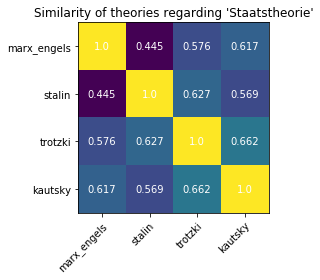

In [145]:
fig, ax = plt.subplots()
    
im = ax.imshow(all_sims)

# We want to show all ticks...
ax.set_xticks(np.arange(len(authors)))
ax.set_yticks(np.arange(len(authors)))
# ... and label them with the respective list entries
ax.set_xticklabels(authors)
ax.set_yticklabels(authors)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(authors)):
    for j in range(len(authors)):
        text = ax.text(j, i, round(all_sims[i][j],3),
                       ha="center", va="center", color="w")

ax.set_title(f"Similarity of theories regarding '{elem}'")
fig.tight_layout()
plt.show()

### For all Theorieelemente

bernstein, gramsci: Politische Ökonomie
bernstein, kautsky: Politische Ökonomie
bernstein, lenin: Politische Ökonomie
bernstein, luxemburg: Politische Ökonomie
bernstein, mao: Politische Ökonomie
bernstein, marx_engels: Politische Ökonomie
bernstein, stalin: Politische Ökonomie
bernstein, thaelmann: Politische Ökonomie
bernstein, trotzki: Politische Ökonomie
gramsci, bernstein: Politische Ökonomie
gramsci, kautsky: Politische Ökonomie
gramsci, lenin: Politische Ökonomie
gramsci, luxemburg: Politische Ökonomie
gramsci, mao: Politische Ökonomie
gramsci, marx_engels: Politische Ökonomie


/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'schuh_n' not in vocabulary of bernstein!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'nase_n' not in vocabulary of bernstein!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'schuh_n' not in vocabulary of gramsci!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'nase_n' not in vocabulary of gramsci!
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:702: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'schuh_n' not in vocabulary of lenin!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'nase_n' not in vocabulary of lenin!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'schuh_n' not in vocabulary of luxemburg!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWar

gramsci, stalin: Politische Ökonomie
gramsci, thaelmann: Politische Ökonomie
gramsci, trotzki: Politische Ökonomie
kautsky, bernstein: Politische Ökonomie
kautsky, gramsci: Politische Ökonomie
kautsky, lenin: Politische Ökonomie
kautsky, luxemburg: Politische Ökonomie
kautsky, mao: Politische Ökonomie
kautsky, marx_engels: Politische Ökonomie
kautsky, stalin: Politische Ökonomie
kautsky, thaelmann: Politische Ökonomie
kautsky, trotzki: Politische Ökonomie
lenin, bernstein: Politische Ökonomie
lenin, gramsci: Politische Ökonomie
lenin, kautsky: Politische Ökonomie
lenin, luxemburg: Politische Ökonomie
lenin, mao: Politische Ökonomie
lenin, marx_engels: Politische Ökonomie
lenin, stalin: Politische Ökonomie
lenin, thaelmann: Politische Ökonomie
lenin, trotzki: Politische Ökonomie
luxemburg, bernstein: Politische Ökonomie
luxemburg, gramsci: Politische Ökonomie
luxemburg, kautsky: Politische Ökonomie
luxemburg, lenin: Politische Ökonomie
luxemburg, mao: Politische Ökonomie
luxemburg, marx

/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'messer_n' not in vocabulary of bernstein!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'regen_n' not in vocabulary of bernstein!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'dialektik_n' not in vocabulary of gramsci!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'messer_n' not in vocabulary of gramsci!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'regen_n' not in vocabulary of gramsci!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'messer_n' not in vocabulary of kautsky!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'messer_n' not in vocabulary of lenin!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'regen_n' not in vocabulary of lenin!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'messer_n' not in vocabulary of luxemburg!

bernstein, luxemburg: Philosophie
bernstein, mao: Philosophie
bernstein, marx_engels: Philosophie
bernstein, stalin: Philosophie
bernstein, thaelmann: Philosophie
bernstein, trotzki: Philosophie
gramsci, bernstein: Philosophie
gramsci, kautsky: Philosophie
gramsci, lenin: Philosophie
gramsci, luxemburg: Philosophie
gramsci, mao: Philosophie
gramsci, marx_engels: Philosophie
gramsci, stalin: Philosophie
gramsci, thaelmann: Philosophie
gramsci, trotzki: Philosophie
kautsky, bernstein: Philosophie
kautsky, gramsci: Philosophie
kautsky, lenin: Philosophie
kautsky, luxemburg: Philosophie
kautsky, mao: Philosophie
kautsky, marx_engels: Philosophie
kautsky, stalin: Philosophie
kautsky, thaelmann: Philosophie
kautsky, trotzki: Philosophie
lenin, bernstein: Philosophie
lenin, gramsci: Philosophie
lenin, kautsky: Philosophie
lenin, luxemburg: Philosophie
lenin, mao: Philosophie
lenin, marx_engels: Philosophie
lenin, stalin: Philosophie
lenin, thaelmann: Philosophie
lenin, trotzki: Philosophie
lu

/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'ei_n' not in vocabulary of bernstein!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'stuhl_n' not in vocabulary of bernstein!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'ei_n' not in vocabulary of gramsci!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'stuhl_n' not in vocabulary of gramsci!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'stuhl_n' not in vocabulary of kautsky!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'ei_n' not in vocabulary of lenin!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'stuhl_n' not in vocabulary of lenin!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'ei_n' not in vocabulary of luxemburg!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'stuhl_n' not in vocabulary of luxemburg!
/usr/lib/python3/d

bernstein, kautsky: Staatstheorie
bernstein, lenin: Staatstheorie
bernstein, luxemburg: Staatstheorie
bernstein, mao: Staatstheorie
bernstein, marx_engels: Staatstheorie
bernstein, stalin: Staatstheorie
bernstein, thaelmann: Staatstheorie
bernstein, trotzki: Staatstheorie
gramsci, bernstein: Staatstheorie
gramsci, kautsky: Staatstheorie
gramsci, lenin: Staatstheorie
gramsci, luxemburg: Staatstheorie
gramsci, mao: Staatstheorie
gramsci, marx_engels: Staatstheorie
gramsci, stalin: Staatstheorie
gramsci, thaelmann: Staatstheorie
gramsci, trotzki: Staatstheorie
kautsky, bernstein: Staatstheorie
kautsky, gramsci: Staatstheorie
kautsky, lenin: Staatstheorie
kautsky, luxemburg: Staatstheorie
kautsky, mao: Staatstheorie
kautsky, marx_engels: Staatstheorie
kautsky, stalin: Staatstheorie
kautsky, thaelmann: Staatstheorie
kautsky, trotzki: Staatstheorie
lenin, bernstein: Staatstheorie
lenin, gramsci: Staatstheorie
lenin, kautsky: Staatstheorie
lenin, luxemburg: Staatstheorie
lenin, mao: Staatsthe

/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'mehl_n' not in vocabulary of bernstein!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'mehl_n' not in vocabulary of gramsci!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'mehl_n' not in vocabulary of lenin!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'mehl_n' not in vocabulary of luxemburg!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'mehl_n' not in vocabulary of mao!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'mehl_n' not in vocabulary of stalin!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'mehl_n' not in vocabulary of thaelmann!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'mehl_n' not in vocabulary of trotzki!


bernstein, stalin: Sozialismusverständnis
bernstein, thaelmann: Sozialismusverständnis
bernstein, trotzki: Sozialismusverständnis
gramsci, bernstein: Sozialismusverständnis
gramsci, kautsky: Sozialismusverständnis
gramsci, lenin: Sozialismusverständnis
gramsci, luxemburg: Sozialismusverständnis
gramsci, mao: Sozialismusverständnis
gramsci, marx_engels: Sozialismusverständnis
gramsci, stalin: Sozialismusverständnis
gramsci, thaelmann: Sozialismusverständnis
gramsci, trotzki: Sozialismusverständnis
kautsky, bernstein: Sozialismusverständnis
kautsky, gramsci: Sozialismusverständnis
kautsky, lenin: Sozialismusverständnis
kautsky, luxemburg: Sozialismusverständnis
kautsky, mao: Sozialismusverständnis
kautsky, marx_engels: Sozialismusverständnis
kautsky, stalin: Sozialismusverständnis
kautsky, thaelmann: Sozialismusverständnis
kautsky, trotzki: Sozialismusverständnis
lenin, bernstein: Sozialismusverständnis
lenin, gramsci: Sozialismusverständnis
lenin, kautsky: Sozialismusverständnis
lenin, 

/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'baum_n' not in vocabulary of bernstein!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'baum_n' not in vocabulary of gramsci!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'haus_n' not in vocabulary of gramsci!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'baum_n' not in vocabulary of lenin!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'baum_n' not in vocabulary of thaelmann!
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: 'haus_n' not in vocabulary of thaelmann!


bernstein, mao: Strategie und Taktik
bernstein, marx_engels: Strategie und Taktik
bernstein, stalin: Strategie und Taktik
bernstein, thaelmann: Strategie und Taktik
bernstein, trotzki: Strategie und Taktik
gramsci, bernstein: Strategie und Taktik
gramsci, kautsky: Strategie und Taktik
gramsci, lenin: Strategie und Taktik
gramsci, luxemburg: Strategie und Taktik
gramsci, mao: Strategie und Taktik
gramsci, marx_engels: Strategie und Taktik
gramsci, stalin: Strategie und Taktik
gramsci, thaelmann: Strategie und Taktik
gramsci, trotzki: Strategie und Taktik
kautsky, bernstein: Strategie und Taktik
kautsky, gramsci: Strategie und Taktik
kautsky, lenin: Strategie und Taktik
kautsky, luxemburg: Strategie und Taktik
kautsky, mao: Strategie und Taktik
kautsky, marx_engels: Strategie und Taktik
kautsky, stalin: Strategie und Taktik
kautsky, thaelmann: Strategie und Taktik
kautsky, trotzki: Strategie und Taktik
lenin, bernstein: Strategie und Taktik
lenin, gramsci: Strategie und Taktik
lenin, kau

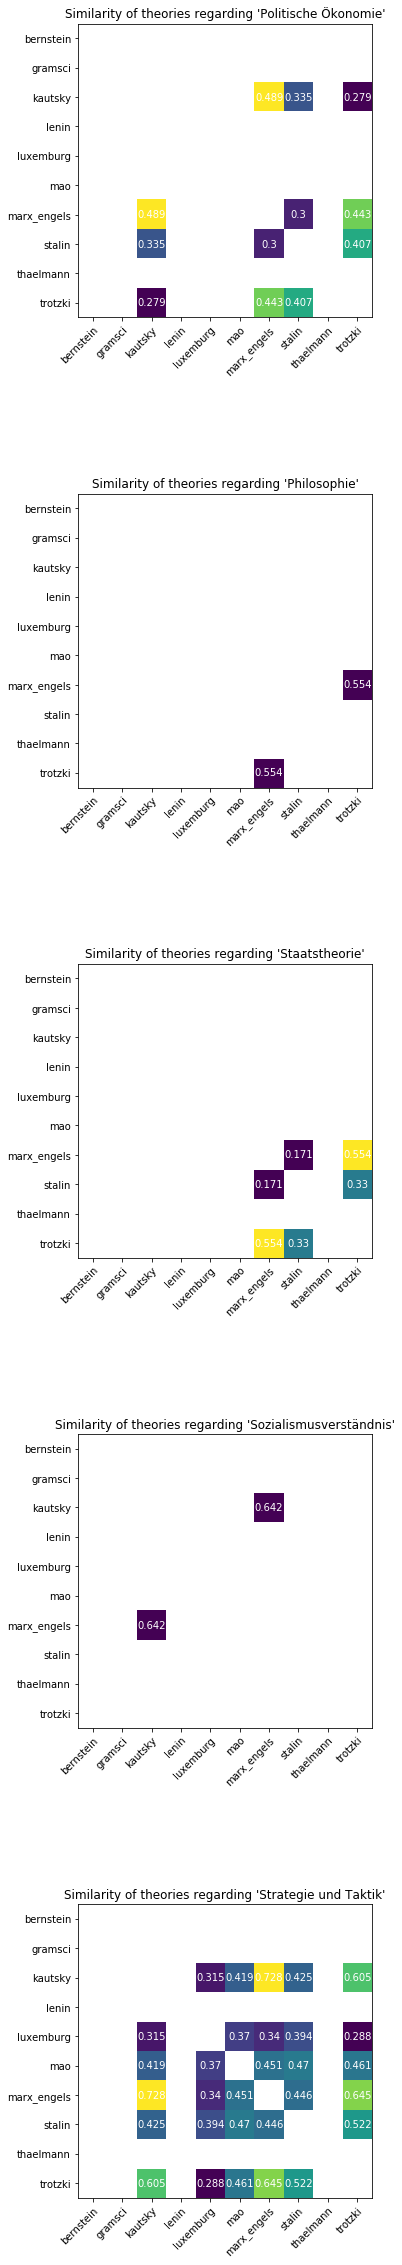

In [52]:
# "cos" for cosine similarity between most similar words
# "rls" for ranked list similarity between most similar words
# "aa"  for cosine between annotated keywords in model trained on whole corpus
# "cnt" for cosine between count vectors
method = "cos"

# minimal similarity for similar words to be taken into account
# use None if it shouldnt be used
threshold = .4

#these_authors = sorted(["marx_engels", "stalin", "trotzki", "kautsky"])
these_authors = sorted(["marx_engels", "stalin", "trotzki", "kautsky", "lenin", "gramsci", "luxemburg", "thaelmann", "bernstein", "mao"])


if method in ["aa", "cnt", "cnt_p"] and threshold is not None:
    warn(f"threshold is not used with '{method}'.")

fig, axes = plt.subplots(len(all_terms), figsize=(10, 40))

results = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))  # store data

for ax, elem in zip(axes, all_terms.keys()):
    all_sims = []
    for a1 in these_authors:
        values = []
        for a2 in these_authors:
            s1, s2 = sorted((a1, a2))
            if a1 == a2:
                values.append(np.nan)
                results[elem][s1][s2] = np.nan
            else:
                v = theory_similarity(a1, a2, elem, method=method, threshold=threshold)
                values.append(v)
                results[elem][s1][s2] = v
        all_sims.append(values)
       
    ax.imshow(all_sims)
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(these_authors)))
    ax.set_yticks(np.arange(len(these_authors)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(these_authors)
    ax.set_yticklabels(these_authors)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(these_authors)):
        for j in range(len(these_authors)):
            ax.text(j, i, round(all_sims[i][j], 3),
                           ha="center", va="center", color="w")

    ax.set_title(f"Similarity of theories regarding '{elem}'")

method_label = method
if threshold is not None and method not in  ["aa", "cnt", "cnt_p"]:
    method_label+= f"_t{int(threshold*10)}"

#fig.tight_layout()
plt.subplots_adjust(hspace=.6)
plt.savefig(f"figures/similarity_heatmap_{method_label}_weird.pdf")

# store data
with open(f"similarities_{method_label}_weird.json", "w") as json_file:
    json.dump(results, json_file)

# Evaluation

## Create stats for machine output

In [4]:
with open("similarities_aa.json") as json_file:
    results = json.load(json_file)
results

{'Politische Ökonomie': {'bernstein': {'bernstein': nan,
   'gramsci': nan,
   'kautsky': 0.5610466202100118,
   'lenin': 0.26644977430502575,
   'luxemburg': 0.390366127093633,
   'mao': 0.3781362920999527,
   'marx_engels': 0.45114607612291974,
   'stalin': 0.38965944945812225,
   'thaelmann': nan,
   'trotzki': 0.4902440011501312},
  'gramsci': {'gramsci': nan,
   'kautsky': nan,
   'lenin': nan,
   'luxemburg': nan,
   'mao': nan,
   'marx_engels': nan,
   'stalin': nan,
   'thaelmann': nan,
   'trotzki': nan},
  'kautsky': {'kautsky': nan,
   'lenin': 0.31456104417641956,
   'luxemburg': 0.3393388018012047,
   'mao': 0.3627624263366063,
   'marx_engels': 0.6226898431777954,
   'stalin': 0.4189011553923289,
   'thaelmann': nan,
   'trotzki': 0.4468165834744771},
  'lenin': {'lenin': nan,
   'luxemburg': 0.2288452312350273,
   'mao': 0.3810918132464091,
   'marx_engels': 0.3141652966539065,
   'stalin': 0.34878995021184284,
   'thaelmann': nan,
   'trotzki': 0.287330483396848},
  'l

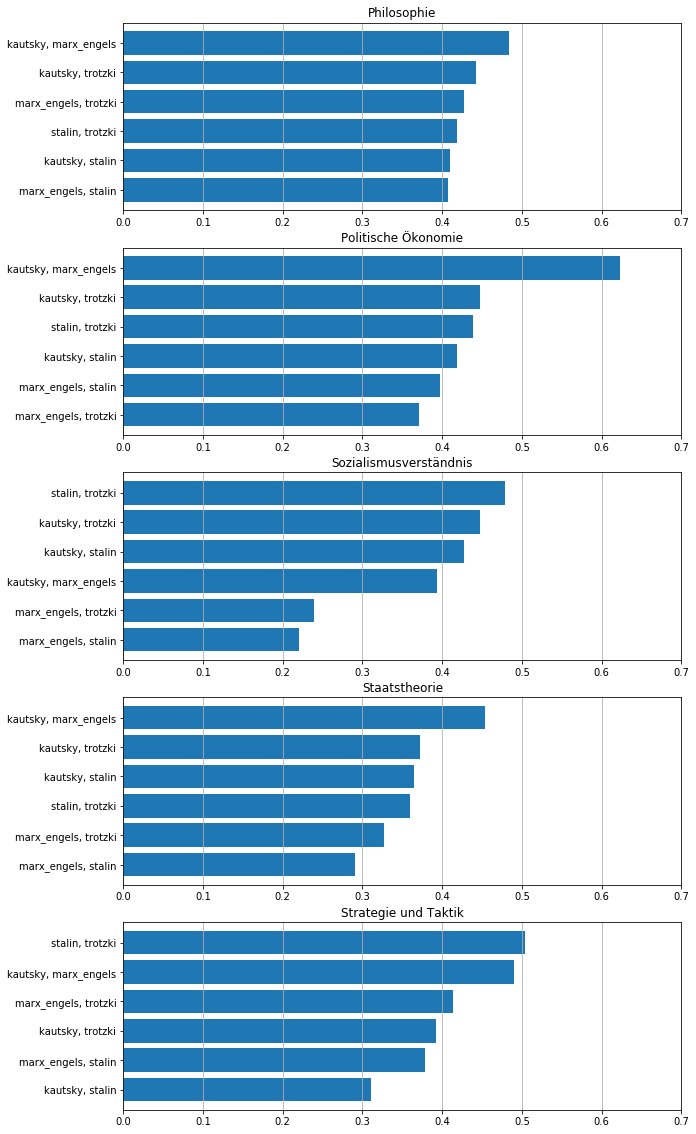

In [19]:
important = ["marx_engels", "stalin", "trotzki", "kautsky"]

fig, axes = plt.subplots(len(term_cats))

for cat, ax in zip(term_cats, axes):
    stats = results[cat]
    # filter doublettes and nans
    stats = [((a1, a2), v) for a1, compares in stats.items() for a2, v in compares.items() if a1 != a2 and not math.isnan(v)]
    # filter unimportant authors
    stats = [e for e in stats if e[0][0] in important and e[0][1] in important]
    stats.sort(key=lambda x: x[1])

    ax.barh([", ".join(x[0]) for x in stats], [x[1] for x in stats])
    ax.set_title(cat)
    ax.set_xlim(0, 0.7)
    ax.grid(axis="x")
# plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
fig.set_size_inches(h=20, w=10)
plt.savefig(f"figures/ranked_{method}.pdf")
plt.show()


## Create Stats for Annotations

### convert into pythonic data structure

In [13]:
def getID(name):
    name = name.lower()
    if name == "marx/engels":
        name = "marx_engels"
    return name

In [30]:
def get_cat(quest):
    trans = {"... ihrer Sozialismusvorstellungen?": "Sozialismusverständnis",
             "... ihrer ontologischen und epistemologischen Vorstellungen?": "Philosophie",
             "... ihres Verständnisses der politischen Ökonomie?": "Politische Ökonomie",
             "... ihrer Vorstellung von Strategie und Taktik?": "Strategie und Taktik",
             "... ihrer Staatstheorie?": "Staatstheorie"}
    return trans[quest]

In [31]:
annos = []
with open('../../annotationen.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in spamreader:
        annos.append(row)

annos = [a[3:-3] for a in annos]
annos_clean = []
for a in annos:
    tmp = []
    for v in a:
        if v == "Sehr unähnlich 1":
            tmp.append("1")
        elif v == "Sehr ähnlich 10":
            tmp.append("10")
        else:
            tmp.append(v)
    annos_clean.append(tmp)
annos = annos_clean

# prepare data structure (list of dicts like above)
annos_struct = [defaultdict(lambda: defaultdict(lambda: defaultdict(int))) for _ in range(len(annos[1:]))]

for i, header in enumerate(annos[0]):
    # seperate topic and authors
    header_parts = re.match(r"(.*) \[(.*)\]", header)
    cat = get_cat(header_parts[1])
    authors = header_parts[2]
    # seperate authors
    authors = re.match(r"(.*) – (.*)", authors)
    a1 = getID(authors[1])
    a2 = getID(authors[2])
    # store values
    for anno, struct in zip(annos[1:], annos_struct):
        struct[cat][a1][a2] = int(anno[i])

for i, anno in enumerate(annos_struct):
    with open(f"similarities_a{i}.json", "w") as json_file:
        json.dump(anno, json_file)
print(annos_struct)

[defaultdict(<function <listcomp>.<lambda> at 0x7f93a3550e18>, {'Sozialismusverständnis': defaultdict(<function <listcomp>.<lambda>.<locals>.<lambda> at 0x7f93697c1950>, {'marx_engels': defaultdict(<class 'int'>, {'stalin': 9, 'trotzki': 4, 'kautsky': 2}), 'stalin': defaultdict(<class 'int'>, {'trotzki': 4, 'kautsky': 2}), 'trotzki': defaultdict(<class 'int'>, {'kautsky': 6})}), 'Politische Ökonomie': defaultdict(<function <listcomp>.<lambda>.<locals>.<lambda> at 0x7f93697c1a60>, {'marx_engels': defaultdict(<class 'int'>, {'stalin': 8, 'trotzki': 7, 'kautsky': 4}), 'stalin': defaultdict(<class 'int'>, {'trotzki': 7, 'kautsky': 4}), 'trotzki': defaultdict(<class 'int'>, {'kautsky': 6})}), 'Philosophie': defaultdict(<function <listcomp>.<lambda>.<locals>.<lambda> at 0x7f93697c1730>, {'marx_engels': defaultdict(<class 'int'>, {'stalin': 7, 'trotzki': 7, 'kautsky': 4}), 'stalin': defaultdict(<class 'int'>, {'trotzki': 7, 'kautsky': 4}), 'trotzki': defaultdict(<class 'int'>, {'kautsky': 4})

### load from json

In [3]:
annos_struct = []
for file in glob.glob("similarities_a[0-9].json"):
    with open(file) as json_file:
        annos_struct.append(json.load(json_file))

### as table

In [22]:
combs = list(combinations(["Marx/Engels", "Stalin", "Trotzki", "Kautsky"], 2))
table = pd.DataFrame(columns=["Kategorie"] + ["–".join(e) for e in combs])
for cat in term_cats:
    row = {"Kategorie":cat}
    for c in combs:
        values = []
        for i in range(3):
            au1 = getID(c[0])
            au2 = getID(c[1])
            try:
                values.append(str(annos_struct[i][cat][au1][au2]))
            except KeyError:
                values.append(str(annos_struct[i][cat][au2][au1]))
        row["–".join(c)] = "/".join(values)
    table = table.append(row, ignore_index=True)

,Kategorie,Marx/Engels–Stalin,Marx/Engels–Trotzki,Marx/Engels–Kautsky,Stalin–Trotzki,Stalin–Kautsky,Trotzki–Kautsky
0,Philosophie,8/7/7,2/7/7,2/7/4,2/9/7,2/9/4,5/9/4
1,Politische Ökonomie,6/9/8,5/8/7,5/8/4,5/9/7,5/8/4,5/8/6
2,Sozialismusverständnis,6/8/9,6/6/4,6/4/2,6/6/4,6/4/2,6/5/6
3,Staatstheorie,7/9/9,1/6/5,1/5/4,1/7/5,1/6/4,1/6/6
4,Strategie und Taktik,6/8/8,2/5/6,2/5/4,1/4/5,1/4/3,1/5/7


In [26]:
print(table.to_latex(index=False))

\begin{tabular}{lllllll}
\toprule
              Kategorie & Marx/Engels–Stalin & Marx/Engels–Trotzki & Marx/Engels–Kautsky & Stalin–Trotzki & Stalin–Kautsky & Trotzki–Kautsky \\
\midrule
            Philosophie &              8/7/7 &               2/7/7 &               2/7/4 &          2/9/7 &          2/9/4 &           5/9/4 \\
    Politische Ökonomie &              6/9/8 &               5/8/7 &               5/8/4 &          5/9/7 &          5/8/4 &           5/8/6 \\
 Sozialismusverständnis &              6/8/9 &               6/6/4 &               6/4/2 &          6/6/4 &          6/4/2 &           6/5/6 \\
          Staatstheorie &              7/9/9 &               1/6/5 &               1/5/4 &          1/7/5 &          1/6/4 &           1/6/6 \\
   Strategie und Taktik &              6/8/8 &               2/5/6 &               2/5/4 &          1/4/5 &          1/4/3 &           1/5/7 \\
\bottomrule
\end{tabular}



### Visualize

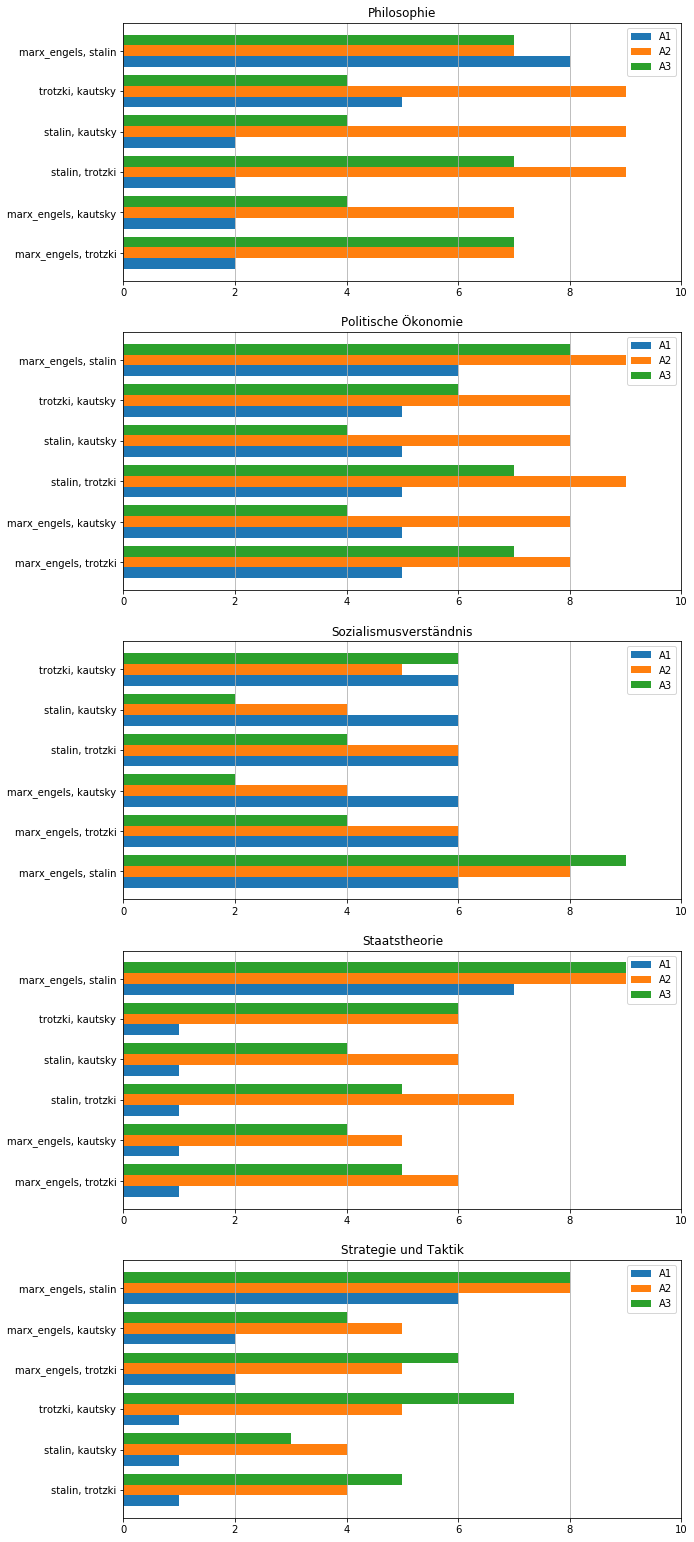

In [33]:
fig, axes = plt.subplots(len(term_cats))

for cat, ax in zip(term_cats, axes):
    reference = annos_struct[0][cat]
    # filter doublettes and nans
    reference = [((a1, a2), v) for a1, compares in reference.items() for a2, v in compares.items() if a1 != a2 and not math.isnan(v)]
    reference.sort(key=lambda x: x[1])
    reference = [x[0] for x in reference]
    
    ind = np.arange(len(reference))
    width = 1/len(annos_struct) - 2/(len(annos_struct)*10)
    
    for i, anno in enumerate(annos_struct):
        values = [anno[cat][a1][a2] for a1, a2 in reference]
        ax.barh(ind+width*i, values, width, label=f"A{i+1}")
    
    shift = width * 0.5 * (len(annos_struct) - 1)
    y_labels = [", ".join(pair) for pair in reference]
    ax.set(yticks=ind+shift, yticklabels=y_labels)
    ax.legend()
    ax.set_title(cat)
    ax.set_xlim(0,10)
    ax.grid(axis="x")

height = len(term_cats) * (4 + 0.5*len(annos_struct))
fig.set_size_inches(h=height, w=10)
plt.savefig(f"figures/annotations.pdf")
plt.show()

## calculate correlations

In [5]:
data = []
for file in glob.glob("similarities_*.json"):
    id = re.match(r"similarities_(.*)\.json", file).groups()[0]
    with open(file) as json_file:
        data.append((id, json.load(json_file)))
data.sort(key=lambda x: x[0])

In [11]:
important = ["marx_engels", "stalin", "trotzki", "kautsky"]
skip_anno = ["a0", "a1", "a2", "gold", "cos_t4_weird"]

correlations = {}
names = []
ps = []

for cat in term_cats:
    rows = []
    for name1, data1 in data:
        if name1 in skip_anno:
            continue
        names.append(name1)
        values1 = []
        for a1, a2 in combinations(important, 2):
            try:
                values1.append(data1[cat][a1][a2])
            except KeyError:
                values1.append(data1[cat][a2][a1])
        
        row = []
        for name2, data2 in data:
            if name2 in skip_anno:
                continue
            values2 = []
            for a1, a2 in combinations(important, 2):
                try:
                    values2.append(data2[cat][a1][a2])
                except KeyError:
                    values2.append(data2[cat][a2][a1])
            rho = spearmanr(values1, values2)
            row.append(rho.correlation)
            ps.append(rho.pvalue)

        rows.append(row)
    correlations[cat] = rows

### for annotators

13


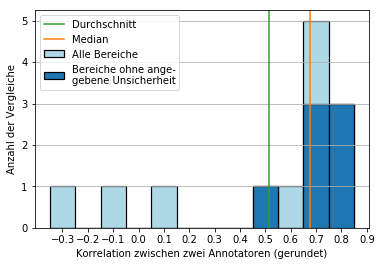

In [44]:
import statistics

anno_cors = []
anno_cors_safe = []
unsafe = ["Philosophie", "Politische Ökonomie"]
for cat in term_cats:
    for i, row in enumerate(correlations[cat][:3]):
        anno_cors += row[i:3]
        if cat not in unsafe:
            anno_cors_safe += row[i:3]
nan = anno_cors[0]
anno_cors = list(filter(lambda x: not math.isnan(x), anno_cors))
mean = sum(anno_cors)/len(anno_cors)
median = statistics.median(anno_cors)

anno_cors = [round(a, 1) for a in anno_cors]
print(len(anno_cors))

xticks = np.arange(start=-.3, stop=1., step=.1) 
plt.hist(anno_cors, bins=xticks-.05, color="lightblue", edgecolor="black", linewidth=1.2, label="Alle Bereiche")
plt.hist(anno_cors_safe, bins= xticks-.05, color="C0", edgecolor="black", linewidth=1.2, label="Bereiche ohne ange-\ngebene Unsicherheit")
plt.xticks(xticks)
plt.axvline(x=mean, color="C2", label="Durchschnitt")
plt.axvline(x=median, color="C1", label="Median")

plt.xlabel("Korrelation zwischen zwei Annotatoren (gerundet)")
plt.ylabel("Anzahl der Vergleiche")
plt.legend()
plt.grid(axis="y")

plt.savefig("figures/annos_correlation_count.pdf")

dict

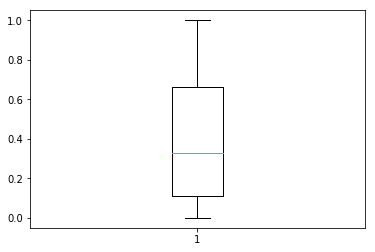

In [45]:
ps = list(filter(lambda x: not math.isnan(x), ps))
type(plt.boxplot(ps))

### create gold standard

In [13]:
important = ["marx_engels", "stalin", "trotzki", "kautsky"]

gold = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))
for cat in term_cats:
    for a1, a2 in combinations(important, 2):
        values = []
        for anno in annos_struct:
            try:
                values.append(anno[cat][a1][a2])
            except KeyError:
                values.append(anno[cat][a2][a1])
        gold[cat][a1][a2] = sum(values)/len(values)

with open("similarities_gold.json", "w") as json_file:
    json.dump(gold, json_file)

### correlations between everyone

In [8]:
# new colormap for correlation values
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Greens', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name="GreenOrange")

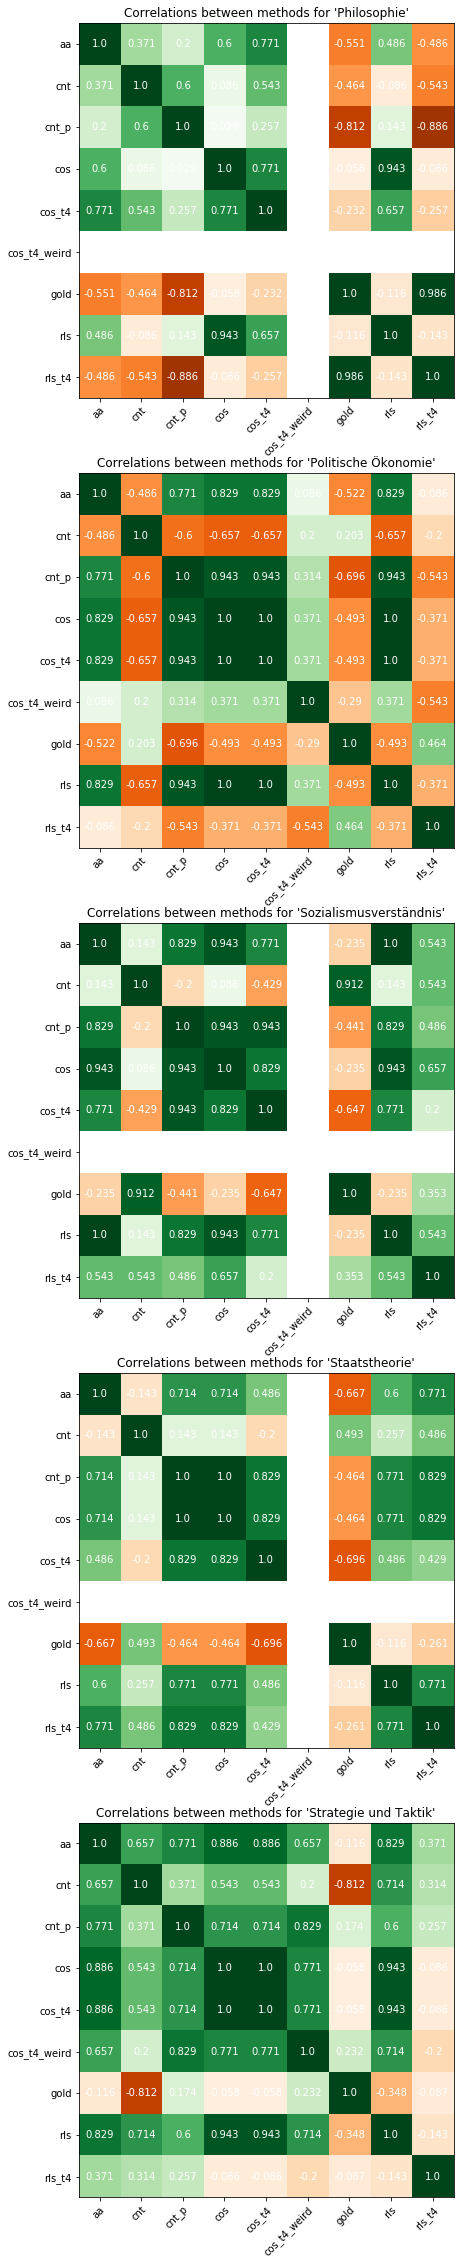

In [9]:
from matplotlib.colors import Normalize

fig, axes = plt.subplots(len(term_cats), figsize=(10, 40))
methods = [d[0] for d in data if d[0] not in skip_anno]

for cat, ax in zip(term_cats, axes):
       
    #ax.imshow([[abs(c) for c in row] for row in correlations[cat]])
    ax.imshow(correlations[cat], cmap=newcmp, norm=Normalize(vmin=-1., vmax=1.))
    #ax.imshow(correlations[cat], cmap=cm.get_cmap("brg"), norm=Normalize(vmin=-1., vmax=1.))
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(methods)))
    ax.set_yticks(np.arange(len(methods)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(methods)
    ax.set_yticklabels(methods)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(correlations[cat])):
        for j in range(len(correlations[cat])):
            ax.text(j, i, round(correlations[cat][i][j], 3),
                           ha="center", va="center", color="w")

    ax.set_title(f"Correlations between methods for '{cat}'")

plt.savefig("figures/correlations.pdf")
plt.show()

### avg correlation between methods

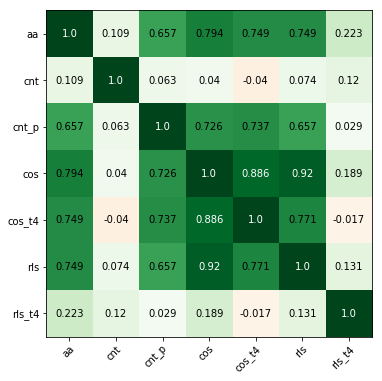

In [12]:
from matplotlib.colors import Normalize

correlations_total = sum([np.array(cor) for cor in correlations.values()])
correlations_avg = correlations_total/len(correlations)


fig, ax = plt.subplots(figsize=(6,6))
methods = [d[0] for d in data if d[0] not in skip_anno]

plt.imshow(correlations_avg, cmap=newcmp, norm=Normalize(vmin=-1., vmax=1.))


# We want to show all ticks...
ax.set_xticks(np.arange(len(methods)))
ax.set_yticks(np.arange(len(methods)))
    
# ... and label them with the respective list entries
ax.set_xticklabels(methods)
ax.set_yticklabels(methods)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(correlations_avg)):
    for j in range(len(correlations_avg)):
        number = round(correlations_avg[i][j], 3)
        col = "w" if number >= .8 else "k"
        ax.text(j, i, number, ha="center", va="center", color=col)

plt.savefig("figures/correlations_metavg.pdf")

### all methods to gold in all categories

In [64]:
data_dict = {d[0]:d[1] for d in data}

In [69]:
important = ["marx_engels", "stalin", "trotzki", "kautsky"]
skip_anno = ["a0", "a1", "a2"]

methods = ['aa', 'cnt', 'cnt_p', 'cos', 'cos_t4', 'rls', 'rls_t4']
#methods = ["cos_t4_weird"]
evaluation = []
ps = []

for met in methods:
    row = []
    for cat in term_cats:
        values_met = []
        for a1, a2 in combinations(important, 2):
            try:
                values_met.append(data_dict[met][cat][a1][a2])
            except KeyError:
                values_met.append(data_dict[met][cat][a2][a1])
        
        values_gold = []
        for a1, a2 in combinations(important, 2):
            try:
                values_gold.append(data_dict["gold"][cat][a1][a2])
            except KeyError:
                values_gold.append(data_dict["gold"][cat][a2][a1])
        
        rho = spearmanr(values_met, values_gold)
        row.append(rho.correlation)
        ps.append(rho.pvalue)
    row.append(sum(row)/len(row))
    row.append(sum(row[2:])/(len(row)-2))
    evaluation.append(row)

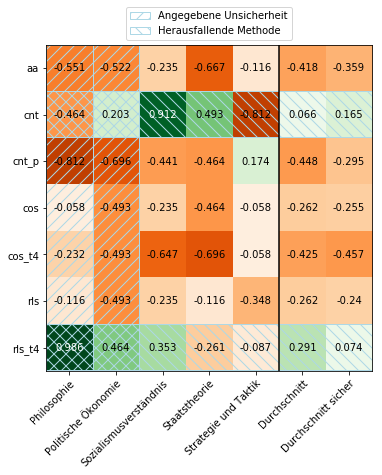

In [70]:
from matplotlib.colors import Normalize


fig, ax = plt.subplots(figsize=(6,6))

plt.imshow(evaluation, cmap=newcmp, norm=Normalize(vmin=-1., vmax=1.))


# We want to show all ticks...
ax.set_xticks(np.arange(len(term_cats)+2))
ax.set_yticks(np.arange(len(methods)))
    
# ... and label them with the respective list entries
ax.set_xticklabels(term_cats + ["Durchschnitt", "Durchschnitt sicher"])
ax.set_yticklabels(methods)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(evaluation)):
    for j in range(len(evaluation[0])):
        number = round(evaluation[i][j], 3)
        col = "w" if number >= .8 else "k"
        ax.text(j, i, number, ha="center", va="center", color=col)

# optical differantiation between avgs and values
plt.axvline(x=4.5, color="k")

# visualisation of unsafe annotations and bad methods
plt.bar([0, 1], [7,7], bottom=[-.5, -.5], fill=False, hatch="//",
        edgecolor="lightblue", width=1, label="Angegebene Unsicherheit")

plt.barh([.98, 5.99], [7,7], left=[-.5, -.5], fill=False, hatch="\\\\",
         edgecolor="lightblue", height=.987, label="Herausfallende Methode" )
plt.legend(loc='lower center', bbox_to_anchor=(.5, 1))
plt.savefig("figures/evaluation.pdf", bbox_inches="tight")
plt.show()

### Clustering 

In [6]:
from scipy.cluster.hierarchy import dendrogram, average
np.set_printoptions(precision=5, suppress=True)

In [7]:
def get_name(nid):
    name = nid.capitalize()
    if name == "Marx_engels":
        name = "Marx/Engels"
    return name

In [32]:
important = ["marx_engels", "stalin", "trotzki", "kautsky"]
calc_reversed = False

this_data = data_dict["cos_t4"]["Sozialismusverständnis"]
condensed = []
for a1, a2 in combinations(authors, 2):
    try:
        this_cond = this_data[a1][a2]
    except KeyError:
        this_cond = this_data[a2][a1]
    if calc_reversed:
        condensed.append(this_cond)
    else:
        condensed.append(1-this_cond)
             
Z = average(condensed)

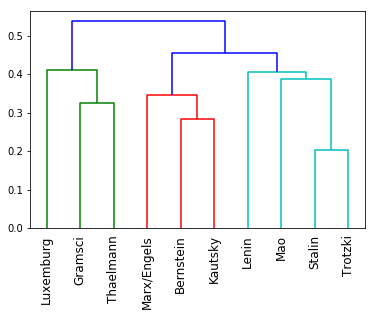

In [34]:
ct = 0.5 if calc_reversed else 0.42
dendrogram(Z, labels=[get_name(a) for a in authors], leaf_rotation=90, color_threshold=ct)
plt.savefig(f"figures/cos_t4_dendrogram{'_rev' if calc_reversed else ''}.pdf", bbox_inches="tight")
plt.show()